In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
import re

In [71]:
def extract_run_time(trial, target):
    for line in trial.split('\n'):
        if target in line:
            print(line)
            time_str = re.findall("\d+\.\d+", line)[0]
            time = float(time_str)
            minutes = 0
            if not line.find('m') == -1 and line.find('ms') == -1:
                minutes = float(line[line.find('m') - 1:line.find('m')]) * 60_000
            # compute units
            unit = line[10 + len(time_str):]
            if unit == 's':
                time *= 1000
            if unit == 'us':
                time /= 1000
            return time + minutes
    return 0.0


def extract_experiments(file_name):
    result = {}
    with open(file_name) as f:
        parsed_json = json.load(f)
        for expt in parsed_json.keys():
            trials = parsed_json[expt]
            trial_times = []
            for trial in trials:
                trial_times.append(extract_run_time(trial, "Test took"))
            avg = np.average(np.array(trial_times))
            result[expt] = avg

    return result

def extract_lt_experiments(file_name):
    result = {}
    with open(file_name) as f:
        parsed_json = json.load(f)
        for reqs in parsed_json.keys():
            trials = parsed_json[reqs]
            latencies = []
            throughputs = []
            for trial in trials:
                lat = extract_run_time(trial, "P99 RTT Lat")
                thr = extract_run_time(trial, "throughput")
                if "lambs" in file_name:
                    lat += 12
                    if thr - 15 > 0:
                        thr -= 8
                latencies.append(lat)
                throughputs.append(thr)
            avg_lat = np.average(np.array(latencies))
            avg_thr = np.average(np.array(throughputs))
            result[reqs] = {}
            result[reqs]["lat"] = avg_lat
            result[reqs]["thr"] = avg_thr

    return result


def aggregate_experiment(paxos_expts, mencius_expts, lambs, epaxos_expts):
    aggregate_expts = {}
    # Assumes each expriment shares the same key
    for expt in paxos_expts.keys():
        paxos_avg = paxos_expts[expt]
        mencius_avg = mencius_expts[expt]
        bug_mencius_avg = lambs[expt]
        epaxos_avg = epaxos_expts[expt]

        aggregate_expts[expt] = ([paxos_avg, mencius_avg, bug_mencius_avg, epaxos_avg], ["paxos", "mencius", "LAMBS", "epaxos"])
    
    return aggregate_expts

def aggregate_lt_experiment(mencius_expts, lambs_expts, epaxos_expts):
    aggregate_expts = {}
    aggregate_expts["lambs"] = {"lat": [], "thr": []}
    aggregate_expts["mencius"] = {"lat": [], "thr": []}
    aggregate_expts["epaxos"] = {"lat": [], "thr": []}
    for reqs in epaxos_expts.keys():
        lambs_lat_avg = lambs_expts[reqs]["lat"]
        lambs_thr_avg = lambs_expts[reqs]["thr"]
        mencius_lat_avg = mencius_expts[reqs]["lat"]
        mencius_thr_avg = mencius_expts[reqs]["thr"]
        epaxos_lat_avg = epaxos_expts[reqs]["lat"]
        epaxos_thr_avg = epaxos_expts[reqs]["thr"]

        aggregate_expts["lambs"]["lat"].append(lambs_lat_avg)
        aggregate_expts["lambs"]["thr"].append(lambs_thr_avg)
        aggregate_expts["mencius"]["lat"].append(mencius_lat_avg)
        aggregate_expts["mencius"]["thr"].append(mencius_thr_avg)
        aggregate_expts["epaxos"]["lat"].append(epaxos_lat_avg)
        aggregate_expts["epaxos"]["thr"].append(epaxos_thr_avg)
    
    return aggregate_expts



In [76]:
def plot_expt(axes, i, j, row, col, aggregate_expts):
    (expt_avgs, expt_labels) = aggregate_expts[str(col) + "," + str(row)]

    # Define a list of colors for the bars
    colors = ['blue', 'green', 'red', "orange"]

    # Create the bar plot
    # plt.figure(figsize=(8, 6))  # Adjust figure size as desired
    axes[i, j].bar(expt_labels, expt_avgs, color=colors)

    axes[i, j].set_title(f"C:{col}, W:{row}")

    # Set x-axis tick positions to center bars
    axes[i, j].set_xticklabels(expt_labels, rotation=0)  # Adjust rotation for long labels


def plot_eval_grid(paxos_fn, mencius_fn, lambs_fn, epaxos_fn):
    # Extract experiment data for all protocols
    paxos_expts = extract_experiments(paxos_fn)
    mencius_expts = extract_experiments(mencius_fn)
    bug_mencius_expts = extract_experiments(lambs_fn)
    epaxos_expts = extract_experiments(epaxos_fn)


    # aggregate different expts into format for plotting
    aggregate_expts = aggregate_experiment(paxos_expts, mencius_expts, bug_mencius_expts, epaxos_expts)

    # Create a 3x4 grid of subplots (adjust as needed for 12 graphs)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

    # Plot each bar graph on a corresponding subplot
    for i, row in enumerate([0, 50, 100]):
        for j, col in enumerate([-1, 0, 50, 100]):
            plot_expt(axes, i, j, row, col, aggregate_expts)
    
    # Add common labels and title for the entire figure
    fig.suptitle("Equal Workload Evaluation", fontsize=12)
    fig.supylabel("Completion time (ms)")
    fig.supxlabel("Protocols")

    # Adjust spacing between subplots
    plt.tight_layout()

    plt.show()

def plot_eval(paxos_fn, mencius_fn, lambs_fn, epaxos_fn):
    # Extract experiment data for all protocols
    paxos_expts = extract_experiments(paxos_fn)
    mencius_expts = extract_experiments(mencius_fn)
    bug_mencius_expts = extract_experiments(lambs_fn)
    epaxos_expts = extract_experiments(epaxos_fn)


    # aggregate different expts into format for plotting
    aggregate_expts = aggregate_experiment(paxos_expts, mencius_expts, bug_mencius_expts, epaxos_expts)

    # Create a 3x4 grid of subplots (adjust as needed for 12 graphs)
    (expt_avgs, expt_labels) = aggregate_expts["50,50"]

    # Define a list of colors for the bars
    colors = ['blue', 'green', 'red', "orange"]

    # Create the bar plot
    plt.figure(figsize=(8, 6))  # Adjust figure size as desired
    bars = plt.bar(expt_labels, expt_avgs, color=colors)

    # Add labels and title
    plt.xlabel("Protocols")
    plt.ylabel("Completition Time (ms)")
    plt.title("Skewed, Unif Client Workload Eval")

    # Set x-axis tick positions to center bars
    plt.xticks(range(len(expt_labels)), expt_labels, rotation=0)  # Adjust rotation for long labels

    # Display the graph
    plt.show()

def plot_lt_eval(type, mencius_fn, lambs_fn, epaxos_fn):
    # Extract experiment data for all protocols
    mencius_expts = extract_lt_experiments(mencius_fn)
    lambs_expts = extract_lt_experiments(lambs_fn)
    epaxos_expts = extract_lt_experiments(epaxos_fn)


    # aggregate different expts into format for plotting
    aggregate_expts = aggregate_lt_experiment(mencius_expts, lambs_expts, epaxos_expts)

    print(aggregate_expts)

    mencius_lats = aggregate_expts["mencius"]["lat"]
    mencius_thrs = aggregate_expts["mencius"]["thr"]
    lambs_lats = aggregate_expts["lambs"]["lat"]
    lambs_thrs = aggregate_expts["lambs"]["thr"]
    epaxos_lats = aggregate_expts["epaxos"]["lat"]
    epaxos_thrs = aggregate_expts["epaxos"]["thr"]

    # Plot the curves
    plt.plot(mencius_thrs, mencius_lats, label='Mencius')
    plt.plot(lambs_thrs, lambs_lats, label='LAMBS')
    plt.plot(epaxos_thrs, epaxos_lats, label='ePaxos')

    # Add labels and title
    plt.xlabel('Throughput (requests / ms)')
    plt.ylabel('Latency (ms)')
    plt.title(f'Throughput vs Latency of Protocols ({type})')

    # Display the legend
    plt.legend()

    # Show the plot
    plt.show()



# Skewed vs equal

/tmp/ipykernel_608485/233210330.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, j].set_xticklabels(expt_labels, rotation=0)  # Adjust rotation for long labels
/tmp/ipykernel_608485/233210330.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, j].set_xticklabels(expt_labels, rotation=0)  # Adjust rotation for long labels
/tmp/ipykernel_608485/233210330.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, j].set_xticklabels(expt_labels, rotation=0)  # Adjust rotation for long labels
/tmp/ipykernel_608485/233210330.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, j].set_xticklabels(expt_labels, rotation=0)  # Adjust r

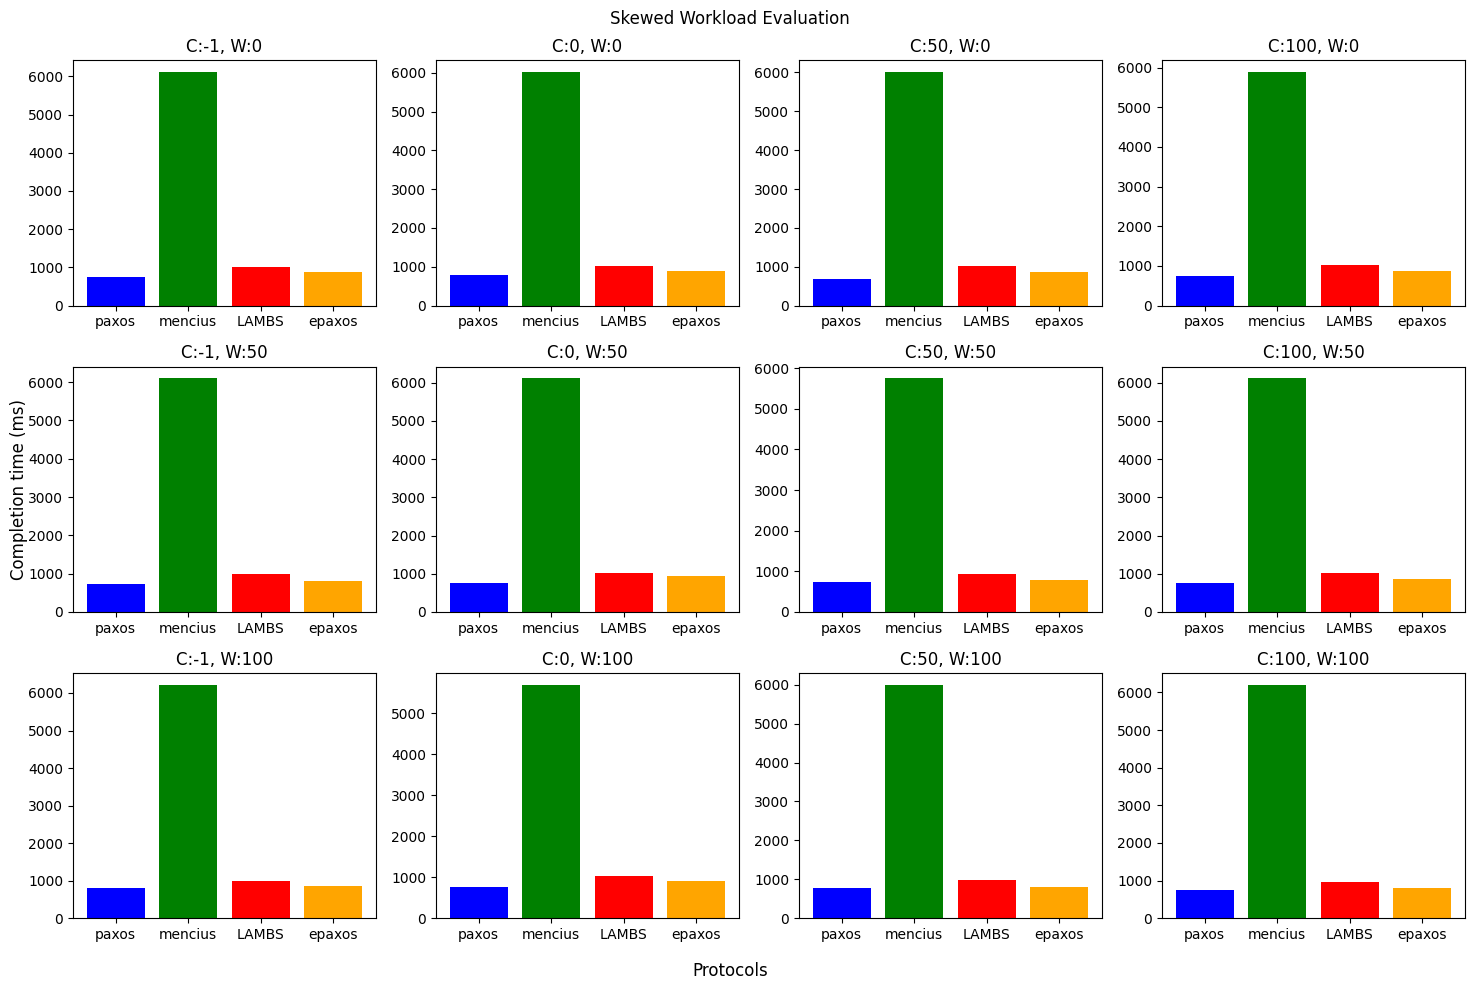

In [34]:
plot_eval_grid("skewed_workload_paxos.json", "skewed_workload_mencius.json", "skewed_workload_lambs.json", "skewed_workload_epaxos.json")

/tmp/ipykernel_608485/973930249.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, j].set_xticklabels(expt_labels, rotation=0)  # Adjust rotation for long labels
/tmp/ipykernel_608485/973930249.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, j].set_xticklabels(expt_labels, rotation=0)  # Adjust rotation for long labels
/tmp/ipykernel_608485/973930249.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, j].set_xticklabels(expt_labels, rotation=0)  # Adjust rotation for long labels
/tmp/ipykernel_608485/973930249.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, j].set_xticklabels(expt_labels, rotation=0)  # Adjust r

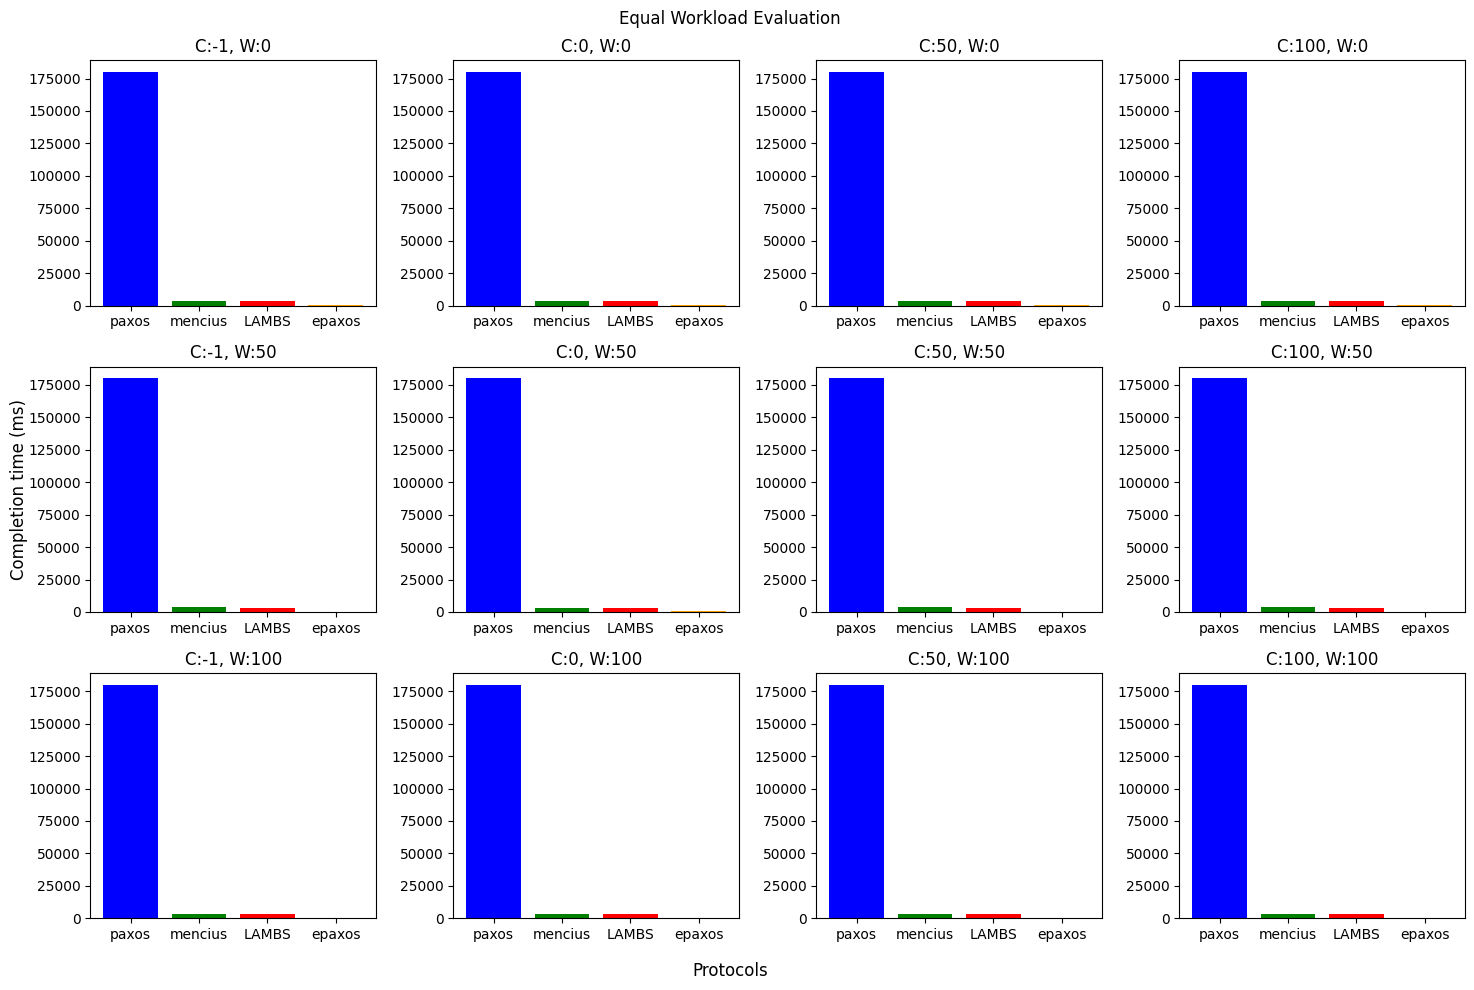

In [36]:
plot_eval_grid("egal_workload_paxos.json", "egal_workload_mencius.json", "egal_workload_lambs.json", "egal_workload_epaxos.json")

# Bursty vs Unif

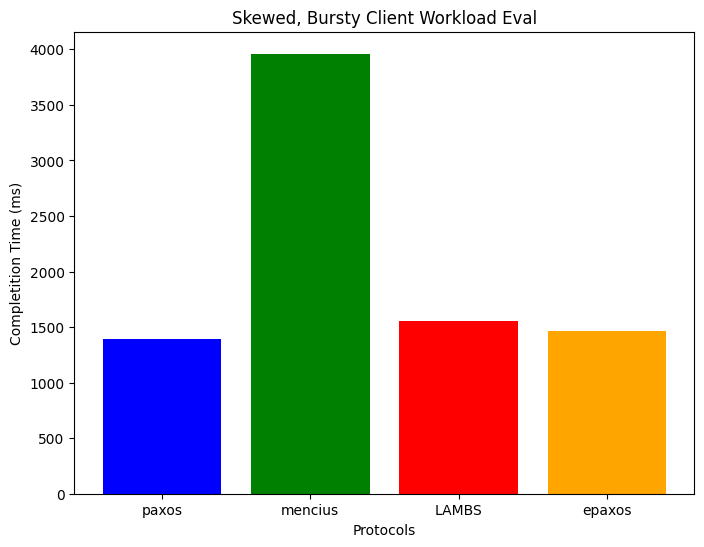

In [30]:
plot_eval("skewed_workload_paxos_bursty.json", "skewed_workload_mencius_bursty.json", "skewed_workload_lambs_bursty.json", "skewed_workload_epaxos_bursty.json")

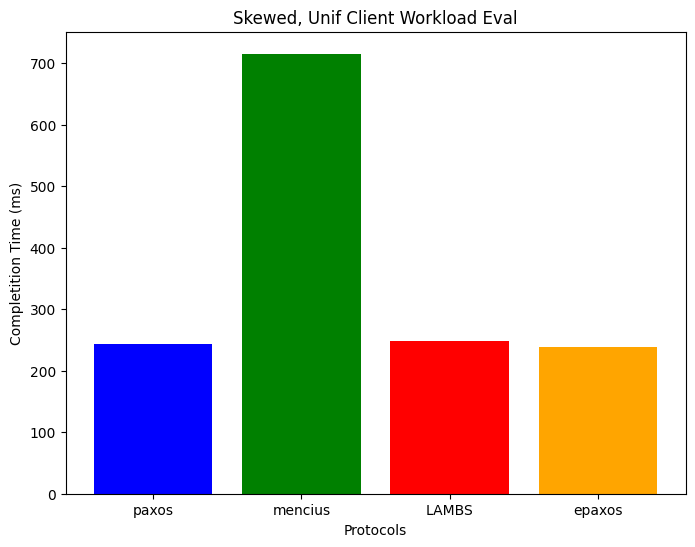

In [32]:
plot_eval("skewed_workload_paxos_unif.json", "skewed_workload_mencius_unif.json", "skewed_workload_lambs_unif.json", "skewed_workload_epaxos_unif.json")

# Latency vs. Throughput

P99 RTT Latency: 6.933691ms
Avg throughput: 14.285714285714286request/ms
P99 RTT Latency: 3.230353ms
Avg throughput: 25.0request/ms
P99 RTT Latency: 6.510585ms
Avg throughput: 14.285714285714286request/ms
P99 RTT Latency: 6.240714ms
Avg throughput: 16.666666666666668request/ms
P99 RTT Latency: 7.271903ms
Avg throughput: 14.285714285714286request/ms
P99 RTT Latency: 6.086045ms
Avg throughput: 55.55555555555556request/ms
P99 RTT Latency: 8.584934ms
Avg throughput: 41.666666666666664request/ms
P99 RTT Latency: 6.56591ms
Avg throughput: 55.55555555555556request/ms
P99 RTT Latency: 6.567365ms
Avg throughput: 50.0request/ms
P99 RTT Latency: 8.389701ms
Avg throughput: 45.45454545454545request/ms
P99 RTT Latency: 9.487777ms
Avg throughput: 58.8235294117647request/ms
P99 RTT Latency: 7.340593ms
Avg throughput: 76.92307692307692request/ms
P99 RTT Latency: 10.222696ms
Avg throughput: 62.5request/ms
P99 RTT Latency: 11.077756ms
Avg throughput: 90.9090909090909request/ms
P99 RTT Latency: 8.603486ms

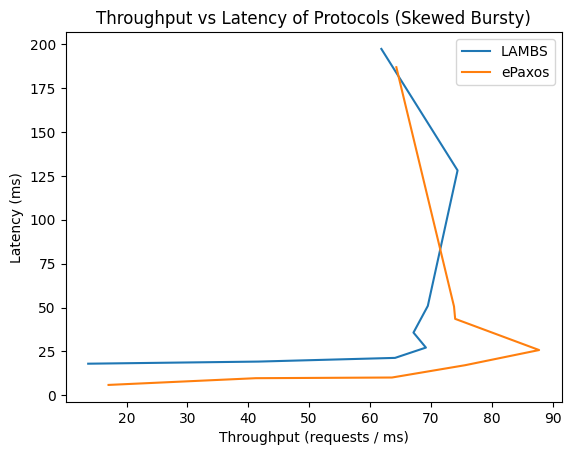

In [69]:
plot_lt_eval("Skewed Bursty", "lt_mencius_bursty.json", "lt_lambs_bursty.json", "lt_epaxos_bursty.json")

P99 RTT Latency: 4.913739ms
Avg throughput: 4.0request/ms
P99 RTT Latency: 1.628615ms
Avg throughput: 20.0request/ms
P99 RTT Latency: 5.903483ms
Avg throughput: 3.3333333333333335request/ms
P99 RTT Latency: 3.756878ms
Avg throughput: 5.0request/ms
P99 RTT Latency: 3.864573ms
Avg throughput: 5.0request/ms
P99 RTT Latency: 5.618435ms
Avg throughput: 16.666666666666668request/ms
P99 RTT Latency: 6.220731ms
Avg throughput: 16.666666666666668request/ms
P99 RTT Latency: 3.844537ms
Avg throughput: 25.0request/ms
P99 RTT Latency: 4.406085ms
Avg throughput: 20.0request/ms
P99 RTT Latency: 7.414352ms
Avg throughput: 12.5request/ms
P99 RTT Latency: 6.818149ms
Avg throughput: 28.571428571428573request/ms
P99 RTT Latency: 5.938623ms
Avg throughput: 28.571428571428573request/ms
P99 RTT Latency: 6.711605ms
Avg throughput: 25.0request/ms
P99 RTT Latency: 3.782369ms
Avg throughput: 40.0request/ms
P99 RTT Latency: 7.477048ms
Avg throughput: 25.0request/ms
P99 RTT Latency: 7.108879ms
Avg throughput: 50.0

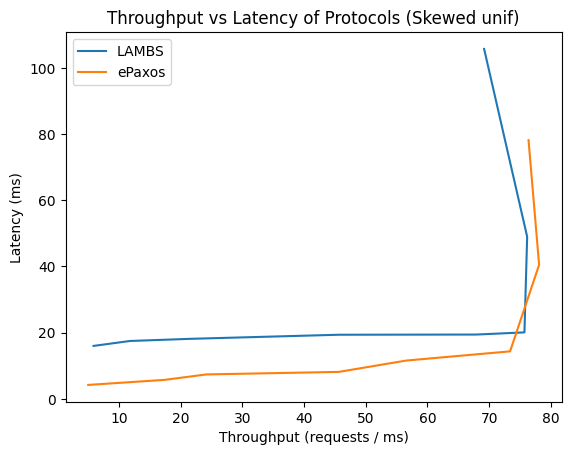

In [70]:
plot_lt_eval("Skewed unif", "lt_mencius_unif.json", "lt_lambs_unif.json", "lt_epaxos_unif.json")

P99 RTT Latency: 4.62467ms
Avg throughput: 20.0request/ms
P99 RTT Latency: 2.343731ms
Avg throughput: 33.333333333333336request/ms
P99 RTT Latency: 4.871822ms
Avg throughput: 20.0request/ms
P99 RTT Latency: 2.587857ms
Avg throughput: 33.333333333333336request/ms
P99 RTT Latency: 3.841981ms
Avg throughput: 25.0request/ms
P99 RTT Latency: 18.440666ms
Avg throughput: 23.80952380952381request/ms
P99 RTT Latency: 12.383864ms
Avg throughput: 31.25request/ms
P99 RTT Latency: 24.864321ms
Avg throughput: 17.857142857142858request/ms
P99 RTT Latency: 33.682373ms
Avg throughput: 13.88888888888889request/ms
P99 RTT Latency: 11.801317ms
Avg throughput: 35.714285714285715request/ms
P99 RTT Latency: 42.38425ms
Avg throughput: 20.833333333333332request/ms
P99 RTT Latency: 43.007391ms
Avg throughput: 20.0request/ms
P99 RTT Latency: 45.097349ms
Avg throughput: 19.607843137254903request/ms
P99 RTT Latency: 32.579705ms
Avg throughput: 25.0request/ms
P99 RTT Latency: 34.930696ms
Avg throughput: 24.39024390

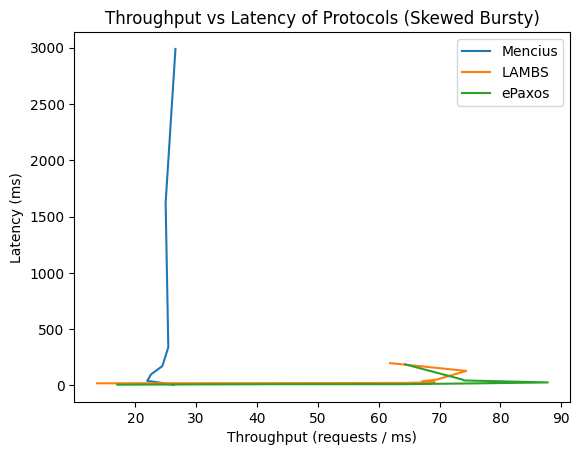

In [77]:
plot_lt_eval("Skewed Bursty", "lt_mencius_bursty.json", "lt_lambs_bursty.json", "lt_epaxos_bursty.json")